In [1]:
# imports
from tqdm import tnrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import gc
import os
%matplotlib inline  
import datetime

# alphabet
import string

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def get_accuracy(logit, target):
    batch_size = len(target)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+nhidden*(noutputs+1)

# define the nnumber of parameters we need
def nparam_MLP(N_INPUTS,N_HIDDEN,N_OUTPUTS):
    input_to_hidden1 = (N_INPUTS+1)*N_HIDDEN #+1 for bias
    hidden1_to_hidden2 = (N_HIDDEN + 1)*N_HIDDEN
    hidden2_to_output = (N_OUTPUTS)*(N_HIDDEN+1)
    return(sum([input_to_hidden1,hidden1_to_hidden2,hidden2_to_output]))


In [3]:
# a prototype MLP
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_neurons, n_output,  device):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs # set the number of neurons in the input layer
        self.n_hidden_neurons = n_hidden_neurons # how many neurons are in each hidden layer
        self.n_output = n_output # set the number of neurons in the output layer
        self.sig = nn.Sigmoid() # set the activation function 
        self.tanh = nn.Tanh()
        self.n_hidden = n_hidden_neurons
        self.encoder = nn.Linear(n_inputs, n_hidden_neurons) # encode input
        self.recurrent = nn.Linear(n_hidden_neurons,n_hidden_neurons) # recurrent connections
        self.decoder = nn.Linear(n_hidden_neurons, n_output) # decode output
                
    def forward(self, x):
        self.hidden1 = self.tanh(self.encoder(x))
        self.hidden2 = self.tanh(self.recurrent(self.hidden1))
        self.output = self.decoder(self.hidden2)
        return self.output
    

In [4]:
# Test MLP on Anna Karenina
# Load Anna Karenina
from torch.utils.data import DataLoader # dataloader 
import sys
sys.path.insert(0,'../final_project/Data/')
from AnnaDataset_MLP import AnnaDataset, InvertAnna # import AK dataset
# from AnnaDataset import AnnaDataset, InvertAnna # import AK dataset
import torchvision
import torchvision.transforms as transforms

# params
BATCH_SIZE = 500 # how many batches we are running
N_STEPS = 10 # How many characters are we inputting into the list at a time
N_HIDDEN_NEURONS = 512 # how many neurons per hidden layer
N_LAYERS = 2 # 2 hidden layers
N_EPOCHS = 50 # how many training epocs
learning_rates = np.asarray([2]) # learning rates
N_REPS = 1 # len(learning_rates) # the number of learning repetitions
gidx = int(N_HIDDEN_NEURONS/2)

# regularization parameters
# lambdas = np.arange(0,1e-2,3e-3,dtype=np.float)
lambdas = np.arange(0,1e-1,1e-2,dtype=np.float) # full sweep
# lambdas = np.arange(0.4,1,0.45) # short sweep
print(lambdas)
# lambdas = np.arange(0,1,1e-1,dtype=np.float) # full sweep
N_LAMBDA = len(lambdas)

# load data
# list all transformations
transform = transforms.Compose(
    [transforms.Normalize((0,), (0.3,))])

dataset = AnnaDataset(N_STEPS) # load the dataset

N_INPUTS = len(dataset.categories)*N_STEPS
N_OUTPUTS = len(dataset.categories)
N_PARAMS = nparam_MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS)


# trainloader = DataLoader(dataset, batch_size=BATCH_SIZE,
#                         shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries
# testloader = DataLoader(dataset, batch_size=BATCH_SIZE,
#                         shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


In [5]:
# test the test-train-validate sampler
# # test_split = torch.split(dataset.onehot_encoded,20,dim=0)
# # print(len(test_split))
# print(dataset.onehot_encoded.shape)
# print(test_split[0].shape)
# print(test_split[1].shape)

# train-test-split
# train_fraction,test_fraction,valid_fraction = (0.8,0.1,0.1)
train_fraction = 0.8

random_seed = 0
shuffle_dataset = True

# from https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets 
# Creating data indices for training and validation splits:
dataset_size = len(dataset.onehot_encoded)
indices = list(range(dataset_size))
train_split = int(np.floor(train_fraction * dataset_size))
print(train_split)
# valid_split = train_split + int(np.floor(valid_fraction * dataset_size))
# test_split = valid_split d+ int(np.floor(test_fraction * dataset_size))

# print(train_split,valid_split,test_split,dataset_size)

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
# train_indices, val_indices, test_indices = indices[:train_split], indices[train_split:valid_split], indices[valid_split:]
train_indices = indices[:train_split]
# val_indices = indices[train_split:valid_split]
# test_indices = indices[valid_split:]
test_indices = indices[train_split:]

print(len(train_indices))
# print(len(val_indices))
print(len(test_indices))

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SequentialSampler(train_indices)
test_sampler = torch.utils.data.SequentialSampler(test_indices)
# valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
#                                            sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                                 sampler=valid_sampler)


# dataset_train,dataset_test = train_test_split(dataset,test_size=0.33, random_state=42)

1566579
1566579
391645


In [6]:
# train-test-validate split

trainloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=4,
                        sampler = train_sampler) # create a DataLoader. We want a batch of BATCH_SIZE entries
# validloader = DataLoader(dataset, batch_size=BATCH_SIZE,
#                         sampler = valid_sampler) # create a DataLoader. We want a batch of BATCH_SIZE entries
testloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4,
                        sampler = test_sampler) # create a DataLoader. We want a batch of BATCH_SIZE entries

In [7]:
# modelkey = ''.join([str(np.random.randint(0,9)) for i in range(10)])

runnow = datetime.datetime.now()
modelkey = str(runnow.isoformat())
print(modelkey)

2019-04-28T16:35:45.389754


In [9]:
# regularizing digonal blocks of the partitioned RNN
# initialize arrays of loss values and weights over the number of epohcs, the number of lambdas we are testing, and the number of reps. 
train_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS)) 
train_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
test_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
test_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
Phist_P = np.zeros((N_PARAMS,N_EPOCHS,N_LAMBDA,N_REPS))

model_P = [None]*N_LAMBDA*N_REPS # array of models
regval_P = [] # array of regularization values

lr = 1e-2
momentum = 0.9

for r in tnrange(N_REPS): # loop over the number of reps
    for k in tnrange(N_LAMBDA): # loop over the number of different lambda values
        reg_lambda = lambdas[k] # set the regularization lambda
        model_path = './models/model_'+modelkey+'_shortrun_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10)) # path to which we will save the model
        model_P[k+r*N_LAMBDA] = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device).to(device) # create the model
        l2_reg = torch.tensor(1,device=device) # create the l2 regularization value tensor
        optimizer = torch.optim.SGD(model_P[k+r*N_LAMBDA].parameters(), lr=lr, momentum=momentum) # set the function for SGD
        criterion = nn.CrossEntropyLoss() # set the loss function
        
        # note that cross-entropy loss expects the indices of the class, not the one-hot. So, for A = [1,0,0,...] and B = [0,1,0,...], A is 0 and B is 1
        
        for epoch in range(N_EPOCHS): # for each training epoch
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_P[k+r*N_LAMBDA].train() 
            for p, param in enumerate(model_P[k+r*N_LAMBDA].parameters()): # go through all the model parameters
                if param.requires_grad:
                    plist = torch.flatten(param.data) # set the list of parameters
                    for j in range(plist.size(0)):
                        while nps < Phist_P.shape[0]:
                            Phist_P[nps,epoch,k,r]=plist[j].item() # update the parameters
                            nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                # print(i,x,y_tar)
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device) # x is the training set, y_tar is the output label
                x = x-0.3
                optimizer.zero_grad() # set gradients to 0
                # print(x.shape)
                y_pred = model_P[k+r*N_LAMBDA](x.view(x.shape[0],x.shape[1]*x.shape[2])) # compute the prediction. # size mismatch
                
                
                loss = criterion(y_pred,y_tar) 
                for p,param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN_NEURONS and param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=1) # update the l1 regularization constant
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=1)
#                         elif param.shape[1]==N_HIDDEN_NEURONS:
#                             l2_reg = l2_reg + param[:,gidx:].norm(p=1)
#                         elif param.shape[0]==N_HIDDEN_NEURONS:
#                             l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_P.append(l2_reg.item()) # add the l2 regularization to  the running list
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE # compute the loss
                loss.backward() # backpropogate the loss
                optimizer.step() # run SGD
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred, y_tar) # compute accuracy
            
            running_test_acc=0
            running_test_loss=0
            model_P[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                x_test = x_test - 0.3
                y_test_pred = model_P[k+r*N_LAMBDA](x_test.view(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
                loss = criterion(y_test_pred,y_test_tar)
                
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred, y_test_tar)
                
            train_loss_P[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_P[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_P[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_P[epoch,k,r] = running_test_acc/len(testloader)
            print("Epoch %d; rep %d; lambda %f; train accuracy %f; train loss %f; test accuracy %f; test loss %f; reg val %f; time %s"
                  %(epoch,
                    r,
                    reg_lambda,
                    train_acc_P[epoch,k,r],
                    train_loss_P[epoch,k,r],
                    test_acc_P[epoch,k,r],
                    test_loss_P[epoch,k,r],
                   l2_reg.item(),
                   str(datetime.datetime.now())))
            
        # save the model and free the memory  
        torch.save(model_P[k+r*N_LAMBDA].state_dict(), model_path)
        model_P[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

Epoch 0; rep 0; lambda 0.000000; train accuracy 30.566050; train loss 2.504377; test accuracy 35.289541; test loss 2.263334; reg val 3199.556152; time 2019-04-28 16:39:17.661750
Epoch 1; rep 0; lambda 0.000000; train accuracy 37.293235; train loss 2.177907; test accuracy 37.821429; test loss 2.148207; reg val 3368.358887; time 2019-04-28 16:40:07.945759
Epoch 2; rep 0; lambda 0.000000; train accuracy 39.848756; train loss 2.067166; test accuracy 40.102041; test loss 2.050313; reg val 3565.511230; time 2019-04-28 16:40:59.819310
Epoch 3; rep 0; lambda 0.000000; train accuracy 42.459796; train loss 1.962239; test accuracy 42.568878; test loss 1.950831; reg val 3763.987793; time 2019-04-28 16:41:51.932330
Epoch 4; rep 0; lambda 0.000000; train accuracy 44.548819; train loss 1.877771; test accuracy 45.035714; test loss 1.868702; reg val 3950.877441; time 2019-04-28 16:42:44.193018
Epoch 5; rep 0; lambda 0.000000; train accuracy 46.308232; train loss 1.811234; test accuracy 46.455357; test 

Epoch 46; rep 0; lambda 0.000000; train accuracy 62.092534; train loss 1.227348; test accuracy 60.608418; test loss 1.280301; reg val 8892.532227; time 2019-04-28 17:19:25.940198
Epoch 47; rep 0; lambda 0.000000; train accuracy 62.196554; train loss 1.223733; test accuracy 60.709184; test loss 1.276182; reg val 8966.767578; time 2019-04-28 17:20:18.561309
Epoch 48; rep 0; lambda 0.000000; train accuracy 62.292916; train loss 1.220214; test accuracy 60.822704; test loss 1.272249; reg val 9040.200195; time 2019-04-28 17:21:11.388584
Epoch 49; rep 0; lambda 0.000000; train accuracy 62.375239; train loss 1.216789; test accuracy 60.946429; test loss 1.268493; reg val 9112.832031; time 2019-04-28 17:22:04.027264
Epoch 0; rep 0; lambda 0.010000; train accuracy 30.485003; train loss 2.560340; test accuracy 35.079082; test loss 2.265384; reg val 2463.884277; time 2019-04-28 17:22:56.744428
Epoch 1; rep 0; lambda 0.010000; train accuracy 37.114231; train loss 2.230585; test accuracy 37.830357; t

Epoch 43; rep 0; lambda 0.010000; train accuracy 60.372049; train loss 1.304305; test accuracy 59.008929; test loss 1.340481; reg val 676.550781; time 2019-04-28 17:59:59.586757
Epoch 44; rep 0; lambda 0.010000; train accuracy 60.469687; train loss 1.299949; test accuracy 59.079082; test loss 1.336268; reg val 670.352661; time 2019-04-28 18:00:51.697043
Epoch 45; rep 0; lambda 0.010000; train accuracy 60.586471; train loss 1.295711; test accuracy 59.195153; test loss 1.332202; reg val 664.225220; time 2019-04-28 18:01:42.955226
Epoch 46; rep 0; lambda 0.010000; train accuracy 60.695278; train loss 1.291583; test accuracy 59.315051; test loss 1.328292; reg val 658.214539; time 2019-04-28 18:02:34.295873
Epoch 47; rep 0; lambda 0.010000; train accuracy 60.798660; train loss 1.287564; test accuracy 59.395408; test loss 1.324531; reg val 652.291260; time 2019-04-28 18:03:27.043108
Epoch 48; rep 0; lambda 0.010000; train accuracy 60.890236; train loss 1.283649; test accuracy 59.480867; test

Epoch 40; rep 0; lambda 0.020000; train accuracy 59.904276; train loss 1.314982; test accuracy 58.336735; test loss 1.365480; reg val 182.070770; time 2019-04-28 18:40:58.251506
Epoch 41; rep 0; lambda 0.020000; train accuracy 60.035099; train loss 1.310068; test accuracy 58.459184; test loss 1.360657; reg val 180.159912; time 2019-04-28 18:41:49.971394
Epoch 42; rep 0; lambda 0.020000; train accuracy 60.168794; train loss 1.305315; test accuracy 58.570153; test loss 1.355917; reg val 178.353851; time 2019-04-28 18:42:41.339263
Epoch 43; rep 0; lambda 0.020000; train accuracy 60.289726; train loss 1.300715; test accuracy 58.667092; test loss 1.351276; reg val 176.657196; time 2019-04-28 18:43:32.686933
Epoch 44; rep 0; lambda 0.020000; train accuracy 60.401085; train loss 1.296259; test accuracy 58.794643; test loss 1.346737; reg val 175.064972; time 2019-04-28 18:44:23.998543
Epoch 45; rep 0; lambda 0.020000; train accuracy 60.514359; train loss 1.291938; test accuracy 58.918367; test

Epoch 37; rep 0; lambda 0.030000; train accuracy 59.508296; train loss 1.331299; test accuracy 57.931122; test loss 1.387093; reg val 109.702286; time 2019-04-28 19:22:20.941207
Epoch 38; rep 0; lambda 0.030000; train accuracy 59.650925; train loss 1.325667; test accuracy 58.067602; test loss 1.381049; reg val 109.504440; time 2019-04-28 19:23:13.543910
Epoch 39; rep 0; lambda 0.030000; train accuracy 59.773772; train loss 1.320237; test accuracy 58.244898; test loss 1.375188; reg val 109.337654; time 2019-04-28 19:24:05.742590
Epoch 40; rep 0; lambda 0.030000; train accuracy 59.925654; train loss 1.314997; test accuracy 58.381378; test loss 1.369506; reg val 109.224983; time 2019-04-28 19:24:57.605128
Epoch 41; rep 0; lambda 0.030000; train accuracy 60.060944; train loss 1.309936; test accuracy 58.511480; test loss 1.364006; reg val 109.144958; time 2019-04-28 19:25:50.112977
Epoch 42; rep 0; lambda 0.030000; train accuracy 60.185386; train loss 1.305044; test accuracy 58.672194; test

Epoch 34; rep 0; lambda 0.040000; train accuracy 59.216656; train loss 1.342100; test accuracy 57.448980; test loss 1.399135; reg val 81.037079; time 2019-04-28 20:00:13.217122
Epoch 35; rep 0; lambda 0.040000; train accuracy 59.378430; train loss 1.335914; test accuracy 57.600765; test loss 1.393168; reg val 81.607048; time 2019-04-28 20:00:59.981564
Epoch 36; rep 0; lambda 0.040000; train accuracy 59.535099; train loss 1.329989; test accuracy 57.766582; test loss 1.387405; reg val 82.194473; time 2019-04-28 20:01:46.977369
Epoch 37; rep 0; lambda 0.040000; train accuracy 59.697192; train loss 1.324306; test accuracy 57.883929; test loss 1.381839; reg val 82.776169; time 2019-04-28 20:02:33.759570
Epoch 38; rep 0; lambda 0.040000; train accuracy 59.834716; train loss 1.318849; test accuracy 58.008929; test loss 1.376446; reg val 83.368111; time 2019-04-28 20:03:20.904578
Epoch 39; rep 0; lambda 0.040000; train accuracy 59.985960; train loss 1.313604; test accuracy 58.173469; test loss

Epoch 31; rep 0; lambda 0.050000; train accuracy 58.571474; train loss 1.365359; test accuracy 56.858418; test loss 1.426437; reg val 65.172691; time 2019-04-28 20:37:00.705913
Epoch 32; rep 0; lambda 0.050000; train accuracy 58.756860; train loss 1.358335; test accuracy 56.997449; test loss 1.420133; reg val 65.813850; time 2019-04-28 20:37:47.602524
Epoch 33; rep 0; lambda 0.050000; train accuracy 58.942565; train loss 1.351624; test accuracy 57.165816; test loss 1.413878; reg val 66.446503; time 2019-04-28 20:38:34.553863
Epoch 34; rep 0; lambda 0.050000; train accuracy 59.126037; train loss 1.345203; test accuracy 57.354592; test loss 1.407655; reg val 67.030228; time 2019-04-28 20:39:21.712794
Epoch 35; rep 0; lambda 0.050000; train accuracy 59.296426; train loss 1.339051; test accuracy 57.506378; test loss 1.401459; reg val 67.601967; time 2019-04-28 20:40:08.437527
Epoch 36; rep 0; lambda 0.050000; train accuracy 59.439375; train loss 1.333146; test accuracy 57.642857; test loss

Epoch 28; rep 0; lambda 0.060000; train accuracy 57.902999; train loss 1.388301; test accuracy 57.114796; test loss 1.414150; reg val 57.244934; time 2019-04-28 21:15:35.581483
Epoch 29; rep 0; lambda 0.060000; train accuracy 58.133695; train loss 1.380129; test accuracy 57.306122; test loss 1.406652; reg val 58.180878; time 2019-04-28 21:16:22.590017
Epoch 30; rep 0; lambda 0.060000; train accuracy 58.339502; train loss 1.372335; test accuracy 57.503827; test loss 1.399690; reg val 59.109585; time 2019-04-28 21:17:09.588270
Epoch 31; rep 0; lambda 0.060000; train accuracy 58.556158; train loss 1.364894; test accuracy 57.678571; test loss 1.393178; reg val 60.014732; time 2019-04-28 21:17:56.481905
Epoch 32; rep 0; lambda 0.060000; train accuracy 58.755584; train loss 1.357784; test accuracy 57.857143; test loss 1.387060; reg val 60.867790; time 2019-04-28 21:18:43.381115
Epoch 33; rep 0; lambda 0.060000; train accuracy 58.944480; train loss 1.350985; test accuracy 58.012755; test loss

Epoch 25; rep 0; lambda 0.070000; train accuracy 57.376835; train loss 1.410600; test accuracy 56.304847; test loss 1.443549; reg val 52.318031; time 2019-04-28 21:52:22.916211
Epoch 26; rep 0; lambda 0.070000; train accuracy 57.629228; train loss 1.401115; test accuracy 56.525510; test loss 1.434585; reg val 53.183735; time 2019-04-28 21:53:09.866600
Epoch 27; rep 0; lambda 0.070000; train accuracy 57.873963; train loss 1.392145; test accuracy 56.761480; test loss 1.426238; reg val 54.012604; time 2019-04-28 21:53:56.943369
Epoch 28; rep 0; lambda 0.070000; train accuracy 58.125080; train loss 1.383656; test accuracy 56.923469; test loss 1.418487; reg val 54.821777; time 2019-04-28 21:54:43.883011
Epoch 29; rep 0; lambda 0.070000; train accuracy 58.333440; train loss 1.375613; test accuracy 57.103316; test loss 1.411272; reg val 55.598255; time 2019-04-28 21:55:31.121886
Epoch 30; rep 0; lambda 0.070000; train accuracy 58.529036; train loss 1.367980; test accuracy 57.336735; test loss

Epoch 22; rep 0; lambda 0.080000; train accuracy 56.506063; train loss 1.441703; test accuracy 55.681122; test loss 1.472582; reg val 45.147125; time 2019-04-28 22:29:13.521417
Epoch 23; rep 0; lambda 0.080000; train accuracy 56.791959; train loss 1.430525; test accuracy 55.918367; test loss 1.462954; reg val 46.071625; time 2019-04-28 22:30:00.703905
Epoch 24; rep 0; lambda 0.080000; train accuracy 57.076579; train loss 1.420011; test accuracy 56.082908; test loss 1.454146; reg val 46.976856; time 2019-04-28 22:30:47.840946
Epoch 25; rep 0; lambda 0.080000; train accuracy 57.343969; train loss 1.410093; test accuracy 56.232143; test loss 1.446071; reg val 47.869095; time 2019-04-28 22:31:34.928199
Epoch 26; rep 0; lambda 0.080000; train accuracy 57.590619; train loss 1.400716; test accuracy 56.392857; test loss 1.438541; reg val 48.719894; time 2019-04-28 22:32:21.832790
Epoch 27; rep 0; lambda 0.080000; train accuracy 57.834078; train loss 1.391830; test accuracy 56.558673; test loss

Epoch 19; rep 0; lambda 0.090000; train accuracy 55.464263; train loss 1.481267; test accuracy 54.321429; test loss 1.524017; reg val 39.000793; time 2019-04-28 23:08:25.516121
Epoch 20; rep 0; lambda 0.090000; train accuracy 55.813019; train loss 1.467230; test accuracy 54.656888; test loss 1.510640; reg val 40.041191; time 2019-04-28 23:09:22.307745
Epoch 21; rep 0; lambda 0.090000; train accuracy 56.169113; train loss 1.454124; test accuracy 54.955357; test loss 1.497961; reg val 41.018600; time 2019-04-28 23:10:18.808904
Epoch 22; rep 0; lambda 0.090000; train accuracy 56.492342; train loss 1.441879; test accuracy 55.234694; test loss 1.485908; reg val 41.957115; time 2019-04-28 23:11:15.493722
Epoch 23; rep 0; lambda 0.090000; train accuracy 56.809190; train loss 1.430422; test accuracy 55.501276; test loss 1.474443; reg val 42.826622; time 2019-04-28 23:12:12.320254
Epoch 24; rep 0; lambda 0.090000; train accuracy 57.099234; train loss 1.419682; test accuracy 55.764031; test loss

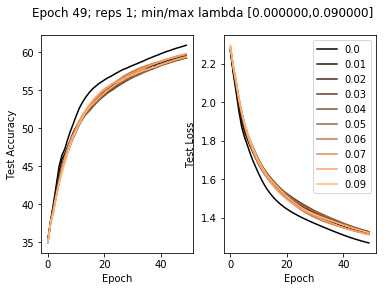

In [10]:

# number of lambdas
n_epochs_plot,n_lambdas_plot = np.mean(test_acc_P,2).shape

fig,ax = plt.subplots(1,2)
fig.subplots_adjust(hspace=20.0)

ax1,ax2 = ax
cm1 = plt.get_cmap('copper') # plt.get_cmap('gist_rainbow') # plt.get_cmap('gist_rainbow')
# fig = plt.figure()
NUM_COLORS = n_lambdas_plot
ax1.set_prop_cycle('color', [cm1(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.set_prop_cycle('color', [cm1(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

fig.suptitle("Epoch %d; reps %d; min/max lambda [%f,%f]"
             %(epoch,
               N_REPS,
               min(lambdas),
               max(lambdas)))

# train accuracy %f; train loss %f; test accuracy %f; test loss %f"
# train_acc_P[epoch,k,r],
#                train_loss_P[epoch,k,r],
#                test_acc_P[epoch,k,r],
#                test_loss_P[epoch,k,r]
            
# ax = fig.add_subplot(111)
for i in enumerate(lambdas):
    ax1.plot(np.mean(test_acc_P,2)[:,i[0]],label=i[1],)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Test Accuracy")
    
# ax2 = fig.add_subplot(011)
for i in enumerate(lambdas):
    ax2.plot(np.mean(test_loss_P,2)[:,i[0]],label=i[1],)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Test Loss")
ax2.legend(loc="upper right")


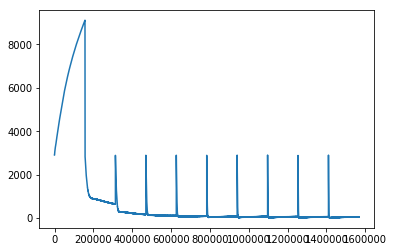

In [11]:
# plt.plot(regval_P)
regval_P_tensor = torch.tensor(regval_P).view(N_EPOCHS,len(lambdas),len(trainloader))
plt.plot(regval_P)

In [ ]:
# # create colormap



# #plt.imshow(x[0,:,:])
# #plt.plot(y_pred.detach().numpy()[0,:])
# #torch.max(y_pred,1)
# plt.figure(1)
# plt.plot(np.mean(test_acc_P,2))
# plt.xlabel("Epoch")
# plt.ylabel("Test accuracy")
# plt.plot()

# plt.figure(2)
# plt.plot(np.mean(test_loss_P,2))
# plt.xlabel("Epoch")
# plt.ylabel("Test loss")
# plt.plot()


# for i,j in enumerate(zip(np.mean(test_acc_P,2),np.mean(test_loss_P,2))):
#     # plt.figure(i+3) # Here's the part I need, but numbering starts at 1!
#     fig,axs = plt.subplots(1,2)
#     fig.suptitle("Epoch %d; reps %d; lambda %f; train accuracy %f; train loss %f; test accuracy %f; test loss %f"
#                   %(epoch,
#                     REPS,
#                     k,
#                     train_acc_P[epoch,k,r],
#                     train_loss_P[epoch,k,r],
#                     test_acc_P[epoch,k,r],
#                     test_loss_P[epoch,k,r]))
#     axs[0].plot(lambdas,j[0])
#     axs[0].set_xlabel("Lambda")
#     axs[0].set_ylabel("Test accuracy")
#     # axs[0].title("Epoch %d"%i)
#     axs[1].plot(lambdas,j[1])
#     axs[1].set_xlabel("Lambda")
#     axs[1].set_ylabel("Test loss")
#     # axs[1].title("Epoch %d"%i)


# # plt.plot(np.mean(test_acc_P,1))
# # plt.plot()

# # plt.plot(np.mean(test_acc_P,2))
# # plt.plot()

# # plt.plot(np.mean(test_acc_P,3))
# # plt.plot()

In [ ]:
# def readtxt(txt_name = 'anna.txt'):
#     dir_path = os.path.dirname(os.path.realpath(__file__))
#     txt_file = os.path.join(dir_path,txt_name)
#     # load the whole book
#     file = open(self.txt_file)
#     alltxt = file.read()
#     # remove newline formmating
#     alltxt = alltxt.replace("\n\n", "&").replace("\n", " ").replace("&", "\n")
#     # define categories
#     categories = list(sorted(set(alltxt)))
#     # integer encode
#     label_encoder = LabelEncoder()
#     label_encoder.fit(categories)
#     integer_encoded = torch.LongTensor(label_encoder.transform(list(alltxt)))
#     return integer_encoded, categories

# # def onehotencode(integer_encoded_batch,n_cat):
    
# # def get_next_batch(dat,batch_size):
# #     x_int = 
# #     y_int = 
# #     x_hot = onehotencode(x_int): 
# #     return x_hot, y_int 
    
    

In [ ]:
import pickle

# BATCH_SIZE = 500 # how many batches we are running
# N_STEPS = 10 # How many characters are we inputting into the list at a time
# N_HIDDEN_NEURONS = 512 # how many neurons per hidden layer
# N_INPUTS = 77*N_STEPS
# N_OUTPUTS = 77
# N_LAYERS = 2 # 2 hidden layers
# N_EPOCHS = 11 # how many training epocs
# learning_rates = np.asarray([2]) # learning rates
# N_REPS = 3 # len(learning_rates) # the number of learning repetitions
# N_PARAMS = nparam_MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS)
# gidx = int(N_HIDDEN_NEURONS/2)


# train_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS)) 
# train_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
# test_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
# test_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
# Phist_P = np.zeros((N_PARAMS,N_EPOCHS,N_LAMBDA,N_REPS))

# model_P = [None]*N_LAMBDA*N_REPS # array of models
# regval_P = [] # array of regularization values



pickle.dump([lambdas,N_EPOCHS,N_REPS,N_HIDDEN_NEURONS,learning_rates,N_REPS,N_PARAMS,
             model_P,regval_P,
             train_loss_P,train_acc_P,
             test_loss_P,test_acc_P,
             Phist_P], 
            open(modelkey+"_mlp_ak_quickset.pkl", "wb" ) )

In [ ]:
# print(test_acc_P.shape)
# plt.plot(np.mean(test_acc_P,2))
# plt.plot()
# print(np.mean(test_acc_P,1))
# print(np.mean(test_acc_P,1).shape)

In [ ]:
# Plot of tensor